In [1]:
import flamp
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

import matrix_functions as mf
from fa_performance import fa_performance

flamp.set_dps(50)  # compute with this many decimal digits precision


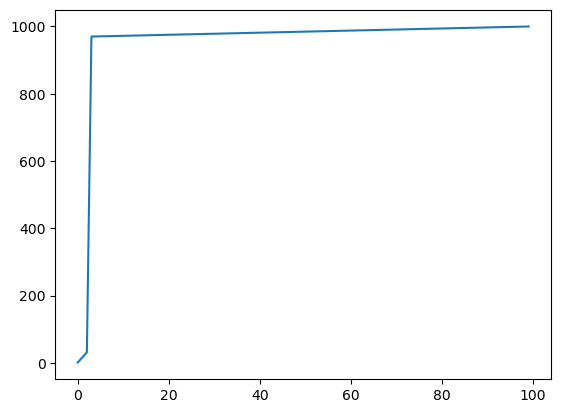

In [2]:
dim = 100
kappa = flamp.gmpy2.mpfr(1_000.)
lambda_min = flamp.gmpy2.mpfr(1.)
lambda_max = kappa * lambda_min

# a_diag = mf.flipped_model_spectrum(dim, kappa, 50, lambda_1=lambda_min)
a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=3, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=1, high_cluster_width=0.25, lambda_1=lambda_min)
# a_diag = mf.utils.linspace(lambda_min, lambda_max, num=dim)
# a_diag = mf.model_spectrum(dim, kappa, .9, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_width=0.001, high_cluster_width=0.5, low_cluster_size=5, lambda_1=lambda_min)

plt.plot(a_diag)

In [3]:
denom_deg = 2
def f(x):
    return x**(-denom_deg)
# f = flamp.sqrt # np.sqrt

mu = a_diag[:-1] + np.diff(a_diag) / 2
# mu = a_diag[1:] - np.diff(a_diag).min()/2
b = mf.start_vec(a_diag, mu)

# b = flamp.ones(dim)
# b = flamp.to_mp(np.flip(mf.model_spectrum(dim, kappa, 0.9)))

# size of Krylov subspace
ks = list(range(1, dim, 10))  # + [dim]


In [4]:
results = fa_performance(f, a_diag, b, ks)
krylov_label = "||\mathrm{opt}_k(I) - f(A)b||_2"
results[f"$q \kappa^q \cdot {krylov_label}$"] = denom_deg * (kappa ** denom_deg) * results[f"${krylov_label}$"]

relative_error = False
if relative_error:
    # notice that it's relative to the *Euclidean* norm of the ground truth
    results /= mf.norm(mf.diagonal_fa(f, a_diag, b))
    error_label = "Relative Error"
else:
    error_label = "Error"

100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


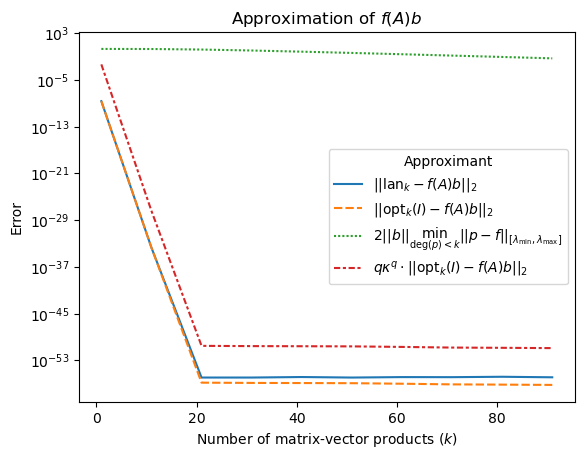

In [5]:
results_long = results.reset_index(names="Number of matrix-vector products ($k$)").melt(
    id_vars=["Number of matrix-vector products ($k$)"], value_name=error_label, var_name="Approximant")

sns.lineplot(x="Number of matrix-vector products ($k$)", y=error_label, hue="Approximant", style="Approximant", data=results_long).set(
    title=f'Approximation of $f(A)b$',
    yscale='log'
);

plt.savefig('output/convergence.svg')

In [6]:
# import scipy.special as sps

# def tyler_inv_sqrt(q, a, b):
#     # In the sidford paper, the approximation is valid in the range [gamma, 1]
#     # that corresponds to [min(abs(lam)), max(abs(lam))] / max(abs(lam))
#     # since sidford's gamma =tyler's sqrt(k2)

#     # lmin = np.min(np.abs(lam))**2
#     # lmax = np.max(np.abs(lam))**2
#     assert 0 < a < b 
#     lmin = a ** 2
#     lmax = b ** 2

#     poles = flamp.zeros(q)
#     weights = flamp.zeros(q)

#     k2 = lmin/lmax  # this is called gamma^2 in the Sidford paper
#     Kp = sps.ellipk(1-k2)  # this is called K prime in the Sidford paper

#     t = 1j*np.arange(1/2,q+1/2)*Kp/q

#     sn_,cn_,dn_,_ = sps.ellipj(np.imag(t),1-k2) # compute real valued functions to transform to what we need

#     cn = 1/cn_
#     dn = dn_ / cn_
#     sn = 1j * sn_ / cn_

#     poles = np.real(lmin * sn**2)

#     weights = (2 * Kp * flamp.sqrt(lmin))/(flamp.gmpy2.const_pi()*q) * (cn * dn)

#     return lambda x: np.sum( weights / (x[:,None]-poles) ,axis=1)

In [7]:
# import baryrat

# running_best_rational_bound = np.inf
# best_rational_bounds = []
# for k in range(99):
#     if k >= 2:
#         ##### WARNING! DON"T HARD CODE THE FUNCTION OK!
#         # aaa_interpolant = baryrat.aaa(np.array(spectrum_discritization, float), np.sqrt, mmax=(k//2))
#         # error = mf.norm(aaa_interpolant(spectrum_discritization) - np.array(f_spectrum_discritization, float), ord=np.inf)
#         # deg_k_error = (kappa ** (k//2)) * error
#         inv_sqrt = tyler_inv_sqrt((k//2), spectrum_discritization.min(), spectrum_discritization.max())
#         zolotarev_interpolant = lambda x: 1./inv_sqrt(x)
#     else:
#         deg_k_error = np.inf

#     running_best_rational_bound = min(running_best_rational_bound, deg_k_error)
#     best_rational_bounds.append(running_best_rational_bound)

# results['rational'] = np.array([min(best_rational_bound[:(k+1)]) for k in ks], dtype=float)

In [8]:
# rational_bound_all_q = []
# for q in range(2,20):
#     rq_inv_sqrt = tyler_inv_sqrt(q, lambda_min, lambda_max)
#     rational_bound_q = []
#     for k in ks:
#         rational_approx_error = mf.norm(f(spectrum_discritization) - 1./rq_inv_sqrt(spectrum_discritization), ord=np.inf)
#         _, residual = flamp.qr_solve(krylov_basis[:, :k], mf.diagonal_fa(rq_inv_sqrt, a_diag, x), res=True) # uh-oh, this is 2-norm optimal, not A-norm optimal
#         krylov_error = mf.norm(residual, ord=np.inf)
#         rational_bound_q.append(rational_approx_error + (kappa ** q) * krylov_error)
#     rational_bound_all_q.append(rational_bound_q)

# results['other'] = np.array(rational_bound_all_q, float).min(axis=0)